## Transfer Learning

Na prática, treinar uma rede convolutiva a partir do zero (com inicialização aleatória), é relativamente raro (conjunto de dados de tamanho suficiente)



Modelos para classificação de imagens com pesos treinados em ImageNet (disponível em Keras)
    * Xception
    * VGG16
    * VGG19
    * ResNet50 
    * InceptionV3
    * InceptionResNetV2
    * MobileNet 
    * DenseNet
    * NASNet
https://keras.io/applications/    

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
workdir_path = '/content/drive/My Drive/exercicio2_RN' #MODIFICAR!!! #Caminho para o seu workspace
os.chdir(workdir_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!pip install keras_tqdm
from keras.models import Sequential, Model,load_model
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
import numpy as np
from keras.applications import  VGG16
from PIL import Image
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.applications.vgg16 import preprocess_input
from keras import losses
from keras.optimizers import RMSprop
from keras_tqdm import TQDMNotebookCallback
from random import randint
import matplotlib.pylab as plt

## Definir uma rede VGG16  (Oxford-2014) 

http://www.robots.ox.ac.uk/~vgg/research/very_deep/

Os vencedores do ILSVRC 2014

http://www.image-net.org/challenges/LSVRC/


O conjunto de dados inclui imagens de 1000 classes e é dividido em três conjuntos (rótulada): 
    
    * Treinamento (imagens 1.3M)
    * Validação (imagens 50K)
    * Testes (imagens de 100K).

``` python
def  VGG_16():
    model = Sequential()
    model.add(Conv2D(64,kernel_size=(3,3),input_shape=(224,224,3),activation='relu',padding='same'))
    model.add(Conv2D(64,kernel_size=(3,3), activation='relu',padding='same'))
    model.add(MaxPooling2D((2,2),strides=(2,2)))
    model.add(Conv2D(128,kernel_size=(3,3), activation='relu',padding='same'))
    model.add(Conv2D(128,kernel_size=(3,3), activation='relu',padding='same'))  
    model.add(MaxPooling2D((2,2),strides=(2,2)))    
    model.add(Conv2D(256,kernel_size=(3,3), activation='relu',padding='same'))
    model.add(Conv2D(256,kernel_size=(3,3), activation='relu',padding='same'))  
    model.add(Conv2D(256,kernel_size=(3,3), activation='relu',padding='same'))  
    model.add(MaxPooling2D((2,2),strides=(2,2)))     
    model.add(Conv2D(512,kernel_size=(3,3), activation='relu',padding='same'))
    model.add(Conv2D(512,kernel_size=(3,3), activation='relu',padding='same'))  
    model.add(Conv2D(512,kernel_size=(3,3), activation='relu',padding='same'))  
    model.add(MaxPooling2D((2,2),strides=(2,2)))      
    model.add(Conv2D(512,kernel_size=(3,3), activation='relu',padding='same'))
    model.add(Conv2D(512,kernel_size=(3,3), activation='relu',padding='same'))  
    model.add(Conv2D(512,kernel_size=(3,3), activation='relu',padding='same'))  
    model.add(MaxPooling2D((2,2),strides=(2,2)))
    model.add(Flatten())
    # Camada superior
    model.add(Dense(4096,activation='relu'))
    model.add(Dense(4096,activation='relu'))
    model.add(Dense(1000,activation='softmax'))
    return model
```

## Carregando a rede VGG16 com os pesos treinados

In [ ]:
model_vgg16= VGG16(weights="imagenet", include_top=True)
model_vgg16.summary()

553467904/553467096 [==============================] - 8s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [ ]:
for i, layer in enumerate(model_vgg16.layers):
    print(i , layer.name, layer.output_shape)

0 input_1 [(None, 224, 224, 3)]
1 block1_conv1 (None, 224, 224, 64)
2 block1_conv2 (None, 224, 224, 64)
3 block1_pool (None, 112, 112, 64)
4 block2_conv1 (None, 112, 112, 128)
5 block2_conv2 (None, 112, 112, 128)
6 block2_pool (None, 56, 56, 128)
7 block3_conv1 (None, 56, 56, 256)
8 block3_conv2 (None, 56, 56, 256)
9 block3_conv3 (None, 56, 56, 256)
10 block3_pool (None, 28, 28, 256)
11 block4_conv1 (None, 28, 28, 512)
12 block4_conv2 (None, 28, 28, 512)
13 block4_conv3 (None, 28, 28, 512)
14 block4_pool (None, 14, 14, 512)
15 block5_conv1 (None, 14, 14, 512)
16 block5_conv2 (None, 14, 14, 512)
17 block5_conv3 (None, 14, 14, 512)
18 block5_pool (None, 7, 7, 512)
19 flatten (None, 25088)
20 fc1 (None, 4096)
21 fc2 (None, 4096)
22 predictions (None, 1000)


## Reconhecendo trens com a rede VGG16

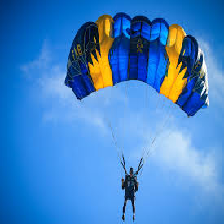

In [ ]:
# Carregando uma nova imagen
imagem=load_img('paraquedas.jpg', target_size=(224,224,3));imagem

In [ ]:
# Transformando a imagem para um tipo array
img_array=img_to_array(imagem).astype('float32')
img_array=img_array.reshape((1,224,224,3));img_array.shape

(1, 224, 224, 3)

In [ ]:
# Evaluando o modelo VGG16

otimizer=SGD(lr=0.1,decay=1e-6,momentum=0.9,nesterov=True)
model_vgg16.compile(optimizer=otimizer,loss='categorical_crossentropy')
saida=model_vgg16.predict(img_array)
print("Classe   : ",np.argmax(saida),"\nPrevisão :",np.max(saida))

Classe   :  701 
Previsão : 0.99396086


https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

## Utilizar uma rede pre-treinada para extrair "features"

Os modelos pre-treinados tem que aprender características (features) das imagens que são aprendidos para diferenciar uma imagem de uma classe de outra classe.

    * Remover as camadas full conected do modelo pre-treinado.
    * Rodar imagens do dataset na rede Truncada para obter "features" do dataset
    * Utilizar os "features" como entrada em outra rede "full conected".

# Extraindo "features"

In [ ]:
# Truncar a rede VGG16
model=Model(inputs=model_vgg16.input,outputs=model_vgg16.get_layer('block5_pool').output)
model.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

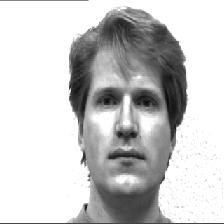

In [ ]:
# Carregando uma nova imagen
imagem=load_img('yalefaces/subject1/subject01.normal.jpg', target_size=(224,224,3));imagem

In [ ]:
# Transformando a imagem para um tipo array
img_array=img_to_array(imagem).astype('float32')
img_array=img_array.reshape((1,224,224,3))
x=preprocess_input(img_array)

In [ ]:
# Obter Caracteristicas de um dado
features=model.predict(x);features.shape

(1, 7, 7, 512)

In [ ]:
# Utilizar data augmentation keras para gerar dados de treinamento y de validação
from dataset_utils import GetRawDataGenerators, GetDataTest,PlotHistory

In [ ]:
chuck=1
X, y, train_generator , valid_generator = GetRawDataGenerators(chuck)
#array_to_img(X[20])

Found 166 images belonging to 15 classes.
Found 166 images belonging to 15 classes.


# Obter Caracteristicas de um dataset (desafio)

In [ ]:
features_train = model.predict_generator(train_generator, steps=chuck)
features_valid = model.predict_generator(valid_generator, steps=chuck)
train_labels , valid_labels = train_generator.y , valid_generator.y

Instructions for updating:
Please use Model.predict, which supports generators.


## Implementação de uma rede "full Conected"

In [ ]:
nub_classes = 15
lr = 0.0001
momentum =0.9
epochs = 50

In [ ]:
model_fcb = Sequential()
model_fcb.add(Flatten(input_shape=features_train.data.shape[1:]))
model_fcb.add(Dense(nub_classes, activation='softmax'))
model_fcb.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 15)                376335    
Total params: 376,335
Trainable params: 376,335
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_fcb.compile(loss=losses.categorical_crossentropy, optimizer=RMSprop(lr=lr), metrics=['accuracy'])
history0 = model_fcb.fit(features_train, train_labels,batch_size=166,epochs=epochs, verbose=1,\
                    validation_data=(features_valid, valid_labels)) 

Epoch 1/50
1/1 [==============================] - 0s 135ms/step - loss: 3.0040 - accuracy: 0.0758 - val_loss: 2.7678 - val_accuracy: 0.0882
Epoch 2/50
1/1 [==============================] - 0s 17ms/step - loss: 2.5648 - accuracy: 0.1591 - val_loss: 2.5755 - val_accuracy: 0.1471
Epoch 3/50
1/1 [==============================] - 0s 17ms/step - loss: 2.3556 - accuracy: 0.2652 - val_loss: 2.5033 - val_accuracy: 0.2059
Epoch 4/50
1/1 [==============================] - 0s 15ms/step - loss: 2.1865 - accuracy: 0.5833 - val_loss: 2.3768 - val_accuracy: 0.4118
Epoch 5/50
1/1 [==============================] - 0s 17ms/step - loss: 2.0475 - accuracy: 0.7348 - val_loss: 2.3011 - val_accuracy: 0.4706
Epoch 6/50
1/1 [==============================] - 0s 19ms/step - loss: 1.9276 - accuracy: 0.8030 - val_loss: 2.2145 - val_accuracy: 0.5588
Epoch 7/50
1/1 [==============================] - 0s 18ms/step - loss: 1.8191 - accuracy: 0.8788 - val_loss: 2.1456 - val_accuracy: 0.5588
Epoch 8/50
1/1 [==========

In [ ]:
score = model_fcb.evaluate(features_valid, valid_labels, verbose=0)
print("\nTest score:", score[0])
print('Test accuracy:', score[1])


Test score: 0.96527099609375
Test accuracy: 0.8235294222831726


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


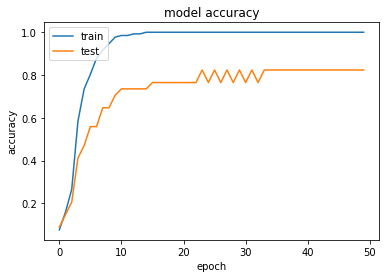

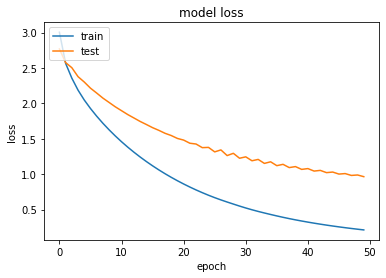

In [ ]:
PlotHistory(history0)

In [ ]:
model_fc = Sequential()
model_fc.add(Flatten(input_shape=features_train.data.shape[1:]))
model_fc.add(Dense(512,activation='relu'))
model_fc.add(Dropout(0.3))
model_fc.add(Dense(256,activation='relu'))
model_fc.add(Dropout(0.2))
model_fc.add(Dense(nub_classes, activation='softmax'))
model_fc.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 15)                3855      
Total params: 12,980,751
Trainable params: 12,980,751
Non-trainable params: 0
__________________________________________

In [ ]:
model_fc.compile(loss=losses.categorical_crossentropy, optimizer=RMSprop(lr=lr), metrics=['accuracy'])

history = model_fc.fit(features_train, train_labels,batch_size=166,epochs=epochs, verbose=1,\
                    validation_data=(features_valid, valid_labels)) 

Epoch 1/50
1/1 [==============================] - 0s 144ms/step - loss: 3.1506 - accuracy: 0.0606 - val_loss: 3.1805 - val_accuracy: 0.1176
Epoch 2/50
1/1 [==============================] - 0s 25ms/step - loss: 2.7465 - accuracy: 0.1439 - val_loss: 2.7474 - val_accuracy: 0.1176
Epoch 3/50
1/1 [==============================] - 0s 25ms/step - loss: 2.5580 - accuracy: 0.2197 - val_loss: 2.4493 - val_accuracy: 0.0882
Epoch 4/50
1/1 [==============================] - 0s 28ms/step - loss: 2.4652 - accuracy: 0.2348 - val_loss: 2.0461 - val_accuracy: 0.4706
Epoch 5/50
1/1 [==============================] - 0s 24ms/step - loss: 1.9470 - accuracy: 0.4242 - val_loss: 2.0560 - val_accuracy: 0.6471
Epoch 6/50
1/1 [==============================] - 0s 24ms/step - loss: 1.6897 - accuracy: 0.5909 - val_loss: 1.7947 - val_accuracy: 0.6176
Epoch 7/50
1/1 [==============================] - 0s 24ms/step - loss: 1.5500 - accuracy: 0.6212 - val_loss: 1.8338 - val_accuracy: 0.6765
Epoch 8/50
1/1 [==========

In [ ]:
score = model_fc.evaluate(features_valid, valid_labels, verbose=0)
print("\nTest score:", score[0])
print('Test accuracy:', score[1])


Test score: 0.5249199271202087
Test accuracy: 0.8529411554336548


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


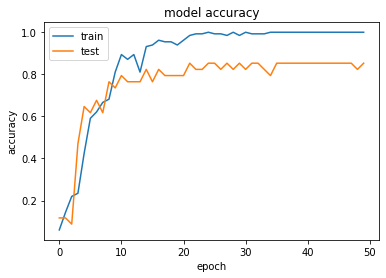

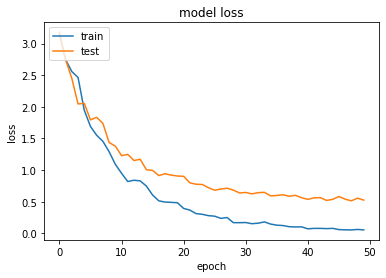

In [ ]:
PlotHistory(history)

# Inferência

In [ ]:
X,y=GetDataTest()

Found 166 images belonging to 15 classes.


In [ ]:
def eval_model(inp, correc_logit):
    vect  = model.predict(inp[np.newaxis,:,:,:])
    logit = model_fc.predict(vect)
    cls = np.argmax(logit,1)[0]
    correc_cls = np.argmax(correc_logit)
    print("previsão sujeito: " + str(cls) )
    print("correct sujeito: " + str(correc_cls)) 
    plt.imshow(inp)
    plt.axis("off")
    plt.show()

previsão sujeito: 14
correct sujeito: 14


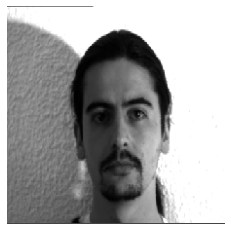

In [ ]:
ind=randint(0,166)
eval_model(X[ind], y[ind])

## Fine Tuning

A diferença é que está também treinar algumas das últimas camadas convolutiva, e treinar a rede resultante com uma taxa de aprendizagem baixa.

## Outras redes CCN
    AlexNet  (2012)
    ZF Net (2013)
    R-CNN (2013)
    GoogLeNet (2015)
    Microsoft ResNet (2015)
    Fast R-CNN (2015)
    Faster R-CNN (2015)

https://adeshpande3.github.io/adeshpande3.github.io/The-9-Deep-Learning-Papers-You-Need-To-Know-About.html